In [1]:
import dask

import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da


import warnings
warnings.filterwarnings('ignore')
from datetime import date

import matplotlib.pyplot as plt

print('loaded libraries')

loaded libraries


In [2]:
mt_path = "/pub/mariant3/WarmWaterMasses/02_tracking-mhws/"
dir_path = "/pub/hfdrake/datasets/CM4_MHW_blobs/"
ds_global = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.01860101-01901231.tos.nc")
static_global = xr.open_dataset(f"{dir_path}/data/ocean_daily_cmip.static.nc")
ds_static_global = xr.merge([static_global,ds_global])

In [3]:
#load all blobs
blobs = xr.open_mfdataset(f"{mt_path}/*blobs.nc")

In [4]:
unique_years = np.unique(blobs.time.dt.year.values)

for i, year in enumerate(unique_years[1:]):
    print(year)
    print(i)
    print(f"year {year} calculation")
    N_before_year = blobs.labels.isel(time=(blobs.time.dt.year==year-1)).max().values
    print(N_before_year)
    blobs["labels"] = xr.where(blobs.time.dt.year==year, blobs.labels + N_before_year, blobs.labels)

187
0
year 187 calculation
56.0
188
1
year 188 calculation
92.0
189
2
year 189 calculation
140.0
190
3
year 190 calculation
198.0


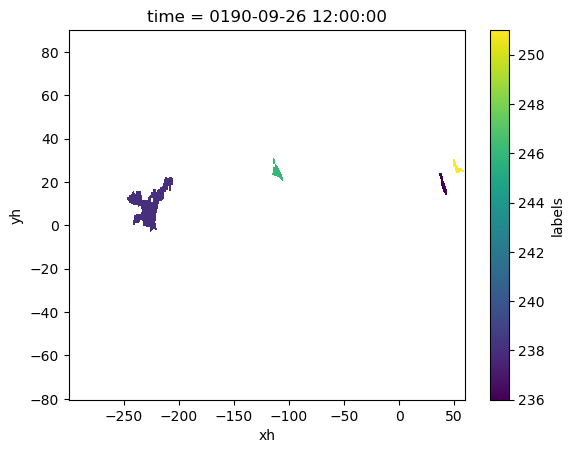

In [5]:
#Check that relabeling worked
blobs.labels.isel(time=830).plot()

In [6]:
ids = np.unique(blobs.labels)
ids = np.array([id for id in ids if ~np.isnan(id)])
ids

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 15

In [7]:
global_blobs = blobs.labels

In [8]:
ds_global_blobs = xr.merge([ds_global,global_blobs],join='inner')
ds_global_blobs

<xarray.Dataset>
Dimensions:     (nv: 2, time: 855, xh: 1440, yh: 1080)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0186-05-03 12:00:00 ... 0190-10-20 12:00:00
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    average_DT  (time) timedelta64[ns] ...
    average_T1  (time) object ...
    average_T2  (time) object ...
    time_bnds   (time, nv) object ...
    tos         (time, yh, xh) float32 ...
    labels      (time, yh, xh) float64 dask.array<chunksize=(171, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.01860101-01901231.tos.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

In [9]:
ds_global_blobs.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:     (nv: 2, time: 855, xh: 1440, yh: 1080)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0186-05-03 12:00:00 ... 0190-10-20 12:00:00
  * xh          (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh          (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    average_DT  (time) timedelta64[ns] ...
    average_T1  (time) object ...
    average_T2  (time) object ...
    time_bnds   (time, nv) object ...
    tos         (time, yh, xh) float32 ...
    labels      (time, yh, xh) float64 dask.array<chunksize=(171, 1080, 1440), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.01860101-01901231.tos.nc
    title:               CM4_piControl_C_restartyear148
    associated_files:    areacello: 01860101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello>

In [10]:
binary_out = ds_global_blobs['tos'] > 29
lsmask = xr.ones_like(binary_out.isel(time=0))

In [12]:
# xarray Dataset to save
ds_out = xr.Dataset(
    data_vars=dict(
        blobs=(['time', 'yh', 'xh'], global_blobs.values, global_blobs.attrs),
        lsmask=(['yh', 'xh'], lsmask.values),

    ),
    coords=dict(
        xh=ds_global_blobs['tos'].xh,
        yh=ds_global_blobs['tos'].yh,
        time=ds_global_blobs['tos'].time,
    ),
    attrs=dict(description="Ocetrac labels",
               data="CM4.0 preprocessed for Ocetrac",
               threshold='>29°C global',
               climatology='entire period'),
)
ds_out

<xarray.Dataset>
Dimensions:  (time: 855, yh: 1080, xh: 1440)
Coordinates:
  * xh       (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * yh       (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * time     (time) object 0186-05-03 12:00:00 ... 0190-10-20 12:00:00
Data variables:
    blobs    (time, yh, xh) float64 nan nan nan nan nan ... nan nan nan nan nan
    lsmask   (yh, xh) bool True True True True True ... True True True True True
Attributes:
    description:  Ocetrac labels
    data:         CM4.0 preprocessed for Ocetrac
    threshold:    >29°C global
    climatology:  entire period

In [13]:
## for nomenclature
d = blobs.isel(time = 0).time.dt
e = blobs.isel(time = -1).time.dt
date_d = f"{d.year.values:0004}{d.month.values:02}{d.day.values:02}"
date_e = f"{e.year.values:0004}{e.month.values:02}{e.day.values:02}"
print(date_d)
print(date_e)

01860503
01901020


In [14]:
ds_out.to_netcdf(f"/pub/mariant3/WarmWaterMasses/02_tracking-mhws/{date_d}-{date_e}_ocetrac-labels-globe.nc")